In [46]:
import os
import math
import pickle
import random
import datetime
import copy
import torch
from torch.nn import Module
import tqdm
import numpy as np 
import gym
from gym import Env
from gym.spaces import Box
from gym.utils.env_checker import check_env
from typing import (
    OrderedDict,
    List,
    Tuple,
    Callable,
)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import stable_baselines3
from stable_baselines3 import A2C
from stable_baselines3.common.env_checker import check_env

In [25]:
print(stable_baselines3.__version__)
print(gym.__version__) # should be 0.21.0 to be compatible with stable_baselines3 1.8

1.8.0
0.21.0



#### mvp
- See if there is transfer from learning regression models from a couple different sine curves to yet a different sine curve.
- We know there is transfer is (1) it takes less to train and (2) if the model chooses to reuse layers rather than create new ones.
- We first train regression models without the meta-learner (because the 'meta' ability cannot do anything without pre-trained weights).
- The meta-learner will then output actions to build a model for unseen data.
- Actions will be continuous, a vector of probabilities corresponding to which layer to add from the layer pool. One of these probabilities corresponds to adding no layer and just training the architecture as it is.

In [28]:
import math
N = 100
lower_bound = -5
upper_bound = 5

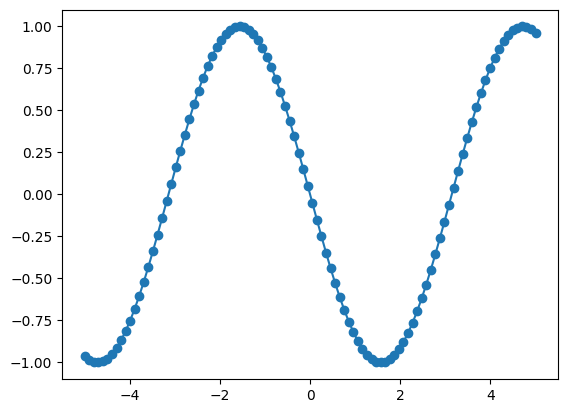

In [29]:
plt.plot(np.linspace(upper_bound, lower_bound, N), np.sin(np.linspace(lower_bound, upper_bound, N)), marker='o')

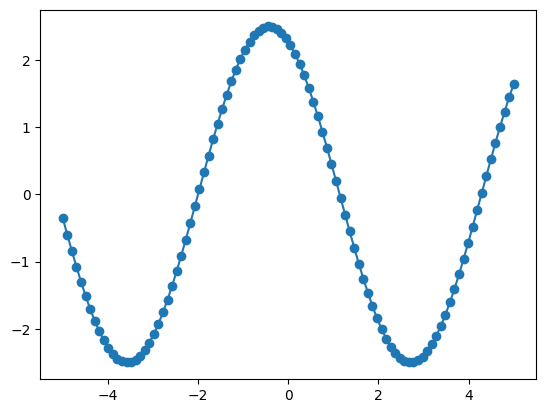

In [30]:
amp = 2.5
phase_shift = 2
plt.plot(np.linspace(lower_bound, upper_bound, N), amp*np.sin([x + phase_shift for x in np.linspace(lower_bound, upper_bound, N)]), marker='o')
# increasing amplitude to 2.5 with phase shift 2

In [31]:
x = np.linspace(lower_bound, upper_bound, N) 

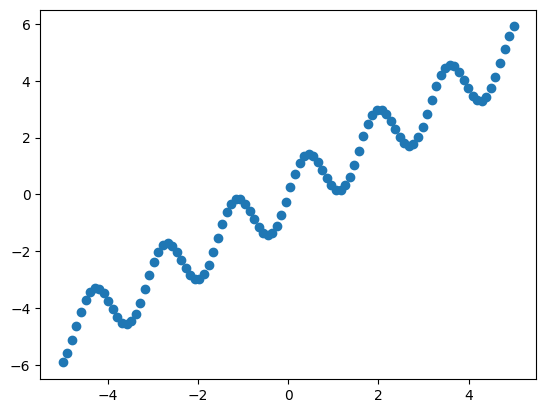

In [32]:
sine_wave = x+ np.sin(4*x)
plt.plot(x, sine_wave, 'o');

In [33]:
# y
sine_wave

array([-5.91294525, -5.57799287, -5.13369394, -4.63533166, -4.14689556,
       -3.73077667, -3.43772005, -3.29865286, -3.31970381, -3.48121619,
       -3.74091343, -4.04070726, -4.31605229, -4.50634033, -4.56466078,
       -4.46535507, -4.20814872, -3.81819555, -3.34202691, -2.84005829,
       -2.37685997, -2.01075871, -1.78444474, -1.71809697, -1.8061334 ,
       -2.01810999, -2.30362341, -2.60042798, -2.84445968, -2.98015301,
       -2.96938931, -2.7976353 , -2.47628357, -2.0408179 , -1.54509897,
       -1.05269063, -0.62662361, -0.319245  , -0.16378838, -0.1690218 ,
       -0.31783582, -0.5699988 , -0.8686358 , -1.1493877 , -1.35077561,
       -1.4241014 , -1.34129005, -1.09941082, -0.72114926, -0.25115391,
        0.25115391,  0.72114926,  1.09941082,  1.34129005,  1.4241014 ,
        1.35077561,  1.1493877 ,  0.8686358 ,  0.5699988 ,  0.31783582,
        0.1690218 ,  0.16378838,  0.319245  ,  0.62662361,  1.05269063,
        1.54509897,  2.0408179 ,  2.47628357,  2.7976353 ,  2.96

In [53]:
def build_model():
    return torch.nn.Sequential(
        torch.nn.Linear(1, 24),
        torch.nn.ReLU(),
        torch.nn.Linear(24, 24), # hidden layer 1
        torch.nn.ReLU(),
        torch.nn.Linear(24, 24), # hidden layer 2
        torch.nn.ReLU(),
        torch.nn.Linear(24, 1)
    )

def save_model(model: torch.nn.Module,path: str) -> None:
    torch.save(model.state_dict(), path)

def load_model(model: torch.nn.Module, path: str) -> torch.nn.Module:
    model.load_state_dict(torch.load(path))    
    
def split_data(X: np.ndarray, y: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    # wraps sklearn's train_test_split
    # added functionality is converting to torch tensor type and reshaping
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    return X_train, y_train, X_test, y_test

def predict_from_composed_layers(layers, X=np.linspace(-2,2,100)):
    y_hats = []
    for x in X:
        x = torch.Tensor([x])
        for i in range(len(layers)-1):
            x = torch.nn.functional.relu(layers[i](x))
        x = layers[-1](x) # do not relu the very last calculation
        y_hats.append(x)
    return y_hats

def predict(model: torch.nn.Module, X: torch.Tensor) -> List[torch.Tensor]:
    # function to get yhat from target network
    return [model(torch.tensor(sample).float()) 
            for sample in X.reshape((N,1))]

def plot_predictions_versus_ground(X: torch.Tensor, y: torch.Tensor, y_hat: torch.Tensor, plot_title: str="line fit") -> None:

    # function to plot predicted curve versus actual curve
    # assumes x and y are both numpy arrays
    # assumes y_hat is generated by make_predictions()
    plt.plot(X, y)
    plt.plot(X, np.array([_.detach().numpy() for _ in y_hat]));
    plt.title(plot_title)

def calculate_pool_size(num_tasks, network_depth):
    k = 1
    return num_tasks * network_depth * k


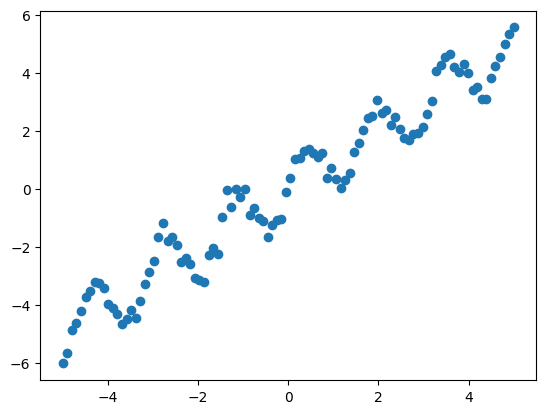

In [63]:
# noisy data
x = np.linspace(lower_bound, upper_bound, N) 
noise = np.random.normal(0, 0.2, 100)
noisy_sine_wave = x + np.sin(4*x) + noise
noisy_X_train, noisy_y_train, noisy_X_test, noisy_y_test = split_data(x_for_split, noisy_sine_wave)

plt.plot(x, noisy_sine_wave, 'o');

## sinusoidal datasets as defined in MAML paper

In [60]:
n_x = 100
n_sets = 10
x_values = np.linspace(lower_bound, upper_bound, n_x) 
amplitude_range = [0.1, 5.0]
phase_range = [0, math.pi]
amps = np.linspace(amplitude_range[0], amplitude_range[1], n_sets)
phases = np.linspace(phase_range[0], phase_range[1], n_sets)
x = np.linspace(lower_bound, upper_bound, n_x) 
sin_sets = [
    (x, (a * np.sin(x)) + p) 
    for (a, p) in zip(amps, phases)]

# split this within training
# X_train, y_train, X_test, y_test = split_data(x.reshape((n_x, 1)), sine_wave)
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)


## global training params

In [64]:
POOL_NUM_LAYERS=100
NETWORK_DEPTH=5
NETWORK_NUM_NODES=32
SEED=123
LOSS_FN=torch.nn.MSELoss()
EPOCHS=1000
NUM_TASKS=20
MODEL=build_model()
OPT=torch.optim.Adam(MODEL.parameters(), lr=0.0001)
TIMESTEPS=20000
DEVICE='cpu'

def reset_env(**kwargs):
    MODEL=build_model()
    OPT=torch.optim.Adam(MODEL.parameters(), lr=0.0001)

def print_env():
    print(f'POOL_NUM_LAYERS  {POOL_NUM_LAYERS}')
    print(f'NETWORK_DEPTH  {NETWORK_DEPTH}')
    print(f'NETWORK_NUM_NODES  {NETWORK_NUM_NODES}')
    print(f'NUM_TASKS  {NUM_TASKS}')
    print(f'SEED  {SEED}')
    print(f'LOSS_FN  {LOSS_FN}')
    print(f'EPOCHS  {EPOCHS}')
    print(f'MODEL  {MODEL}')
    print(f'OPT  {OPT}')
    print(f'TIMESTEPS  {TIMESTEPS}')
    print(f'DEVICE  {DEVICE}')

print_env()

POOL_NUM_LAYERS  100
NETWORK_DEPTH  5
NETWORK_NUM_NODES  32
NUM_TASKS  20
SEED  123
LOSS_FN  MSELoss()
EPOCHS  1000
MODEL  Sequential(
  (0): Linear(in_features=1, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=24, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24, out_features=1, bias=True)
)
OPT  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
TIMESTEPS  20000
DEVICE  cpu


## reinforcement meta-learning (reml) / "Learning to learn by gradient descent by reinforcement learning"

3 classes
- layer pool
- target network -- composed of layers from layer pool
- meta learner -- decides which layers from layer pool to add to target network

So, (meta learner) -> (layer pool) -> (target network)

In [48]:
print_env()

POOL_NUM_LAYERS  100
NETWORK_DEPTH  5
NETWORK_NUM_NODES  32
NUM_TASKS  20
SEED  123
LOSS_FN  MSELoss()
EPOCHS  1000
MODEL  Sequential(
  (0): Linear(in_features=1, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=24, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24, out_features=1, bias=True)
)
OPT  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
TIMESTEPS  20000
DEVICE  cpu


In [49]:
class Layer:
    def __init__(self, 
                layer: torch.nn.Linear):
        self.layer = layer
        self.used = False
        self.times_used = 0

class LayerPool:
    '''Pool of dense layers, each with a specified number of nodes to be composed by the RL agent.
    '''
    # TODO(ms): accomodate dimensions beyond 1D
    def __init__(self, 
                size: int, 
                input_dim: int,
                output_dim: int,
                num_nodes_per_layer: int=32):
        self.size = size
        self.num_nodes_per_layer = num_nodes_per_layer

        # these layers comprise the layer pool
        # each layer has a metadata object associated with it that stores useful information
        # each layer that is used gets updated (i.e., their parameters change and the copy in 
        # this layer pool is updated)
        # the one exception to this update rule is the first and last layers in the network,
        # or 'initial' and 'final', below
        self.layers = {
            id : Layer(layer) 
            for id, layer in enumerate([torch.nn.Linear(in_features=num_nodes_per_layer, out_features=num_nodes_per_layer) for _ in range(size)])}
        [torch.nn.init.xavier_uniform_(layer_obj.layer.weight) for layer_obj in self.layers.values()]


        print('[INFO] Pool of size {0} created.'.format(size))
        print('[INFO] Pool contains layers with input_dim {0}, output_dim {1}, and num_nodes {2}.'.format(input_dim, output_dim, num_nodes_per_layer))



In [51]:
# train with new layer first before predicting? (yes)
# pass through the dataset multiple times per epoch? (yes, up to (training steps / # of data points) times)
# replace layers? (no)
class TargetNetwork(gym.Env, Module):
    # TODO(ms): do experiment to see whether replacing layers on modulo improves performance; currently, only passing through
    # the dataset multiple times on modulo
    def __init__(self, 
                task: List[np.ndarray], 
                layer_pool: LayerPool,
                num_layers_per_network: int=5,
                step_size: float=0.01,
                epsilon: float=0.1):
        super(TargetNetwork, self).__init__()
        # latent space (calculation before final layer)
        self.observation_space = Box(low=float('-inf'), high=float('inf'), shape=(layer_pool.num_nodes_per_layer,)) 
        # probability vector (action as layer within pool)
        self.action_space = Box(low=0., high=1., shape=(layer_pool.size,)) 
        self.epsilon = epsilon
        self.X = task[0]
        self.y = task[1]
        self.input_dim = self.X.shape
        self.output_dim = self.y.shape
        # modulo pointer to pass through datasets more than once (i.e., (training steps / # of datapoints) times)
        self.curr_i = 0
        self.curr_x = torch.Tensor( [self.X[0]] )
        self.curr_y = torch.Tensor( [self.y[0]] ) 
        self.layer_pool = layer_pool
        # initial and final layers are tweaked for each new env/task
        self.initial_layer = torch.nn.Linear(self.input_dim, self.layer_pool.num_nodes_per_layer) 
        self.final_layer = torch.nn.Linear(self.layer_pool.num_nodes_per_layer, self.output_dim) 
        torch.nn.init.xavier_uniform_(self.final_layer.weight)
        torch.nn.init.xavier_uniform_(self.initial_layer.weight)
        self.num_layers_per_network = num_layers_per_network
        self.layers = torch.nn.ModuleList([self.layer_pool.initial_layer, self.layer_pool.final_layer]) # every target network begins with the same initial and final layers
        self.state = self.reset() 
        self.pool_indices = [] 
        self.loss_fn = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.layers.parameters(), lr=step_size)

        print('[INFO] TargetNetwork instantiated for task {0}. Layers per network: {1}; step size: {2}; epsilon: {3}'.format(task, num_layers_per_network, step_size, epsilon))

    def step(self, action: np.ndarray) -> Tuple[torch.Tensor, int, bool, dict]: # "given some new layer"
        if len(self.layers) < self.network_depth:
            pool_index, next_layer = self.epsilon_greedy(action) # action is probability for each layer in pool

            # add new layer in front of final layer
            self.pool_indices.append(pool_index)
            final_layer = self.layers.pop(-1)
            self.layers.append(next_layer)  
            self.layers.append(final_layer) 

        # run target network
        s_prime, reward = self.forward_pass()
        done = False # TODO(ms): update to make episodic? is this continuous learning?

        return (
            s_prime,
            reward, 
            done, 
            {}
        )

    def forward_pass(self) -> Tuple[np.ndarray, float]: 
        # NOTE Design choice whether to train with new layer first. Currently training first.
        self.train()
        self.curr_i  = (self.curr_i + 1) % len(self.X) # go through data multiple times / dataset does not dictate truncation condition
        self.curr_x = torch.Tensor( [self.X[self.curr_i]] ) 
        self.curr_y = torch.Tensor( [self.y[self.curr_i]] )

        def predict(x):
            for i in range(len(self.fcs) - 1): # -1 because we don't want the last output layer yet
                x = torch.nn.functional.relu(self.fcs[i](x))
            s_prime = x
            y_hat = self.fcs[-1](x) # calculated separately to return reward
        
            return self.loss_fn(self.curr_y, y_hat), s_prime, self.loss_fn(self.curr_y, y_hat) # (loss, s', reward)

        # update params
        loss, s_prime, reward = predict(self.curr_x)
        self.opt = torch.optim.Adam(self.fcs.parameters(), lr=self.step_size) # re-create because parameters added
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        # return updated state and reward
        # NOTE  This is the second time we call predict. The first time was used to train the model.
        _, s_prime, reward = predict(self.curr_x)

        return s_prime.detach().numpy().T.squeeze(), float(reward.detach().numpy()) # (s', reward)

    
    def epsilon_greedy(self, probabilities):
        if random.random() <= self.epsilon:
            pool_index = random.randint(0, len(probabilities)-1)
        else:
            pool_index = np.argmax(probabilities)

        return pool_index, self.layer_pool.layers[pool_index].layer

    def reset(self) -> np.ndarray:
        # BUG  Stablebaselines3 seems to call the reset() method even when we're not terminating.
        # self.fcs = torch.nn.ModuleList([self.layer_pool.initial_layer, self.layer_pool.final_layer])

        initial_x = torch.Tensor( [self.X[0]] )
        initial_state = torch.nn.functional.relu(self.layers[0](initial_x))

        initial_state = initial_state.detach().numpy().T.squeeze() # TODO(ms): is there a better way to massage this data?
        print('[INFO] Reset environment to {0}'.format(initial_state))
    
    def render(self, mode='human', close=False):
        print(f'[INFO] # of layers {len(self.layers)}')

    def close(self):
        pass

In [52]:
class Rlmetalearn:
    '''
    Meta-policy. The parameters are learned by training on multiple different tasks, where
    each task is represented by a different dataset (X,y) and is an instance of the 
    TargetNetwork class.

    Uses multiple environmental variables, whose default values are specified with print_env().

    Example usage.
        $ pool = LayerPool(in_features, out_features)  # this assumes the same architecture for every layer in the pool
        $ tasks = { str(round(f))+str("_task") : ((np.linspace(-2, 2, 100), (xvalues/round(f)) + np.sin(4*xvalues) + np.random.normal(0, 0.2, 100) for f in np.linspace(1, 1000, NUM_TASKS)) }
        $ rml = ReinforcementMetaLearning(pool, tasks)  # "you have this pool of layers, now learn these tasks"
        $ rml.train()
        $ rml.introspect(X, y) # TODO(ms): decide what this will do, then how.

    https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html#example

    '''
    def __init__(self,
                layer_pool,
                tasks,
                timesteps=5000,
                device='cpu',
                overwrite=True, 
                intra_update=True,
                network_depth_limit=5,
                network_num_nodes=32,
                epsilon=0.1):
        self.layer_pool = layer_pool
        self.tasks = tasks
        self.out_features = np.array(self.tasks[list(self.tasks.keys())[0]][1]).shape # output shape; assumes uniformity across tasks
        self.timesteps = timesteps
        self.device = device
        self.overwrite = overwrite  # TODO(ms): to implement this, need some filter on the actions returned
        self.intra_update = intra_update
        self.network_depth_limit = network_depth_limit
        self.network_num_nodes = network_num_nodes
        self.epsilon = epsilon
        self.epoch_to_yhats_by_task = {}
        self.epoch_to_layerindices_by_task = {}

    def train(self):
        '''ReML is one policy that gets updated across tasks. We update the env 
        for the meta policy for each new task.
        '''
        epoch_to__task_to_yhats = {}
        epoch_to__task_to_layerindices = {}
        for epoch in range(EPOCHS):
            print(f'[INFO] Epoch {epoch +1}/{EPOCHS}...')

            task_to_yhats = {}
            task_to_layerindices = {}
            for i, (task_id, (X, y)) in enumerate(self.tasks.items()): # loop over tasks
                print(f'[INFO] ...task {i+1}/{len(self.tasks)}')

                # where each task gets its own network
                env = TargetNetwork(X, 
                                    y, 
                                    self.layer_pool,
                                    self.network_depth_limit,
                                    self.network_num_nodes,
                                    self.epsilon)
                
                # update env with new task
                if epoch==0: model  = A2C('MlpPolicy', env) 
                else: model.set_env(env)

                # train reml for 20000 timesteps, which means output output 20000
                # actions to the inner network. Each timestep is an action given to
                # inner network. This in turn is a step in the environment. Therefore
                # we take update the parameters of inner loop and outerloop each 20000
                # times. Timestep in outer is env step in inner. The loss of the inner 
                # network is the reward to outer network.
                #
                # ***question of ratios, to adjust the % of timestemps per task spent on choosing
                # layers versus training layers (here, just 5)
                model.learn(total_timesteps=self.timesteps) # 20000 timesteps 

                # predict and store
                y_hats = predict_from_composed_layers(env.fcs)
                task_to_yhats[task_id] = y_hats
                task_to_layerindices[task_id] = env.layerpool_indices
                print(f'epoch to yhats {task_to_yhats}')
                print(f'epoch to layers {task_to_layerindices}')

                # update
                self.update_params(env.layerpool_indices, env.fcs)
            
            epoch_to_yhats_by_task[epoch] = task_to_yhats
            epoch_to_layerindices_by_task[epoch] = task_to_layerindices
        self.epoch_to_yhats_by_task = epoch_to_yhats_by_task          # { (epoch in 50 epochs) : { (task in 20 tasks) : (100 predictions, where 100 is the number of x values) } } 
        self.epoch_to_layers_by_task = epoch_to_layerindices_by_task  # { (epoch in 50 epochs) : { (task in 20 tasks) : (indices to layer pool, which will have the meta Layer object) } }
        

    def update_params(self, pool_indices, layers):
        # push updated params to pool
        # NOTE  number of layerpool_indices and layers should be 1:1
        for i in range(len(pool_indices)):
            pool_index = pool_indices[i]
            updated_layer_copy = layers[i+1]
            self.layer_pool.layers[pool_index].layer = updated_layer_copy
            self.layer_pool.layers[pool_index].used = True
            self.layer_pool.layers[pool_index].times_used += 1
    
    def save(self):
        time = datetime.datetime.now().strftime("%H:%M:%S").replace(':', '')
        yhats_pkl_name = "{0}_yhats.pkl".format(time)
        indices_pkl_name = "{0}_indices.pkl".format(time)
        pool_pkl_name = "{0}_pool.pkl".format(time)

        with open(yhats_pkl_name, 'wb') as yhats_pkl:
            pickle.dump(self.epoch_to_yhats_by_task, yhats_pkl)

        with open(indices_pkl_name, 'wb') as indices_pkl:
            pickle.dump(self.epoch_to_layers_by_task, indices_pkl)

        with open(pool_pkl_name, 'wb') as pool_pkl:
            pickle.dump(self.layer_pool, pool_pkl)
    
    def load(self):
        paths = os.listdir(os.getcwd())
        yhats_pkl_name = [path for path in paths if 'yhats' in path][0]
        indices_pkl_name =  [path for path in paths if 'indices' in path][0]
        pool_pkl_name =  [path for path in paths if 'pool' in path][0]
        yhats_loaded, indices_loaded, pool_loaded = {}, {}, {}

        with open(yhats_pkl_name, 'rb') as yhats_pkl:
            yhats_loaded = pickle.load(yhats_pkl)

        with open(indices_pkl_name, 'rb') as indices_pkl:
            indices_loaded = pickle.load(indices_pkl)

        with open(pool_pkl_name, 'rb') as pool_pkl:
            pool_loaded = pickle.load(pool_pkl)
        
        return yhats_loaded, indices_loaded, pool_loaded

## Initial test

In [19]:
print_env()

POOL_NUM_LAYERS  100
NETWORK_DEPTH  5
NETWORK_NUM_NODES  32
NUM_TASKS  20
SEED  123
LOSS_FN  MSELoss()
EPOCHS  1000
MODEL  Sequential(
  (0): Linear(in_features=1, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=24, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24, out_features=1, bias=True)
)
OPT  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
TIMESTEPS  20000
DEVICE  cpu


In [64]:
TIMESTEPS=5000

In [70]:
%%time
X = xvalues     # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

layer_pool = LayerPool(size=POOL_NUM_LAYERS, input_dim=in_features, output_dim=out_features, num_nodes=NETWORK_NUM_NODES)
env = TargetNetwork(X, y, layer_pool)

metarl = A2C('MlpPolicy', env)
metarl.learn(total_timesteps=TIMESTEPS)          

CPU times: total: 1min 11s
Wall time: 14.9 s


In [71]:
# performance
y_hats = []
for x in np.linspace(-2,2,100):
    x = torch.Tensor([x])
    for i in range(len(env.fcs)-1):
        x = torch.nn.functional.relu(env.fcs[i](x))
    x = env.fcs[-1](x) # do not relu the very last calculation
    y_hats.append(x)
print(y_hats)

[tensor([-2.3032], grad_fn=<AddBackward0>), tensor([-2.2724], grad_fn=<AddBackward0>), tensor([-2.2407], grad_fn=<AddBackward0>), tensor([-2.2090], grad_fn=<AddBackward0>), tensor([-2.1772], grad_fn=<AddBackward0>), tensor([-2.1438], grad_fn=<AddBackward0>), tensor([-2.1062], grad_fn=<AddBackward0>), tensor([-2.0689], grad_fn=<AddBackward0>), tensor([-2.0323], grad_fn=<AddBackward0>), tensor([-1.9967], grad_fn=<AddBackward0>), tensor([-1.9643], grad_fn=<AddBackward0>), tensor([-1.9330], grad_fn=<AddBackward0>), tensor([-1.9025], grad_fn=<AddBackward0>), tensor([-1.8721], grad_fn=<AddBackward0>), tensor([-1.8426], grad_fn=<AddBackward0>), tensor([-1.8134], grad_fn=<AddBackward0>), tensor([-1.7847], grad_fn=<AddBackward0>), tensor([-1.7580], grad_fn=<AddBackward0>), tensor([-1.7314], grad_fn=<AddBackward0>), tensor([-1.7048], grad_fn=<AddBackward0>), tensor([-1.6782], grad_fn=<AddBackward0>), tensor([-1.6515], grad_fn=<AddBackward0>), tensor([-1.6249], grad_fn=<AddBackward0>), tensor([-1

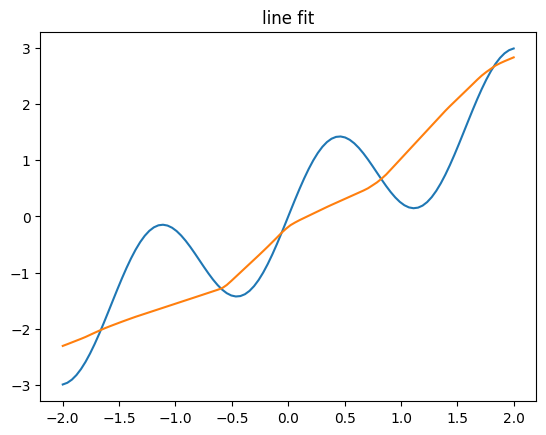

In [72]:
plot_predictions_versus_ground(np.linspace(-2,2,100), sine_wave, y_hats)

## Experiment: increasing # of layers

More layers don't help (this simple example). They do hurt performance somewhat, but after a certain depth, it becomes random and a network with thousands more layers can perform better than a network with thousands more layers less.

### 5 -> 50 depth networks (5 step size)

In [57]:
%%time
X = xvalues # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

depth_to_yhats = {}
for num_layers in np.arange(5, 50, 5):
    reset_env(NUM_LAYERS=num_layers)
    layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
    env = TargetNetwork(
        X, 
        y, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    metarl = A2C('MlpPolicy', env)
    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    print(f'depth {num_layers}:  {y_hats}')
    depth_to_yhats[num_layers] = y_hats

depth 5:  [tensor([-2.6857], grad_fn=<AddBackward0>), tensor([-2.6110], grad_fn=<AddBackward0>), tensor([-2.5245], grad_fn=<AddBackward0>), tensor([-2.4118], grad_fn=<AddBackward0>), tensor([-2.2911], grad_fn=<AddBackward0>), tensor([-2.1597], grad_fn=<AddBackward0>), tensor([-2.0256], grad_fn=<AddBackward0>), tensor([-1.8915], grad_fn=<AddBackward0>), tensor([-1.7573], grad_fn=<AddBackward0>), tensor([-1.6232], grad_fn=<AddBackward0>), tensor([-1.4891], grad_fn=<AddBackward0>), tensor([-1.3549], grad_fn=<AddBackward0>), tensor([-1.2325], grad_fn=<AddBackward0>), tensor([-1.1305], grad_fn=<AddBackward0>), tensor([-1.0286], grad_fn=<AddBackward0>), tensor([-0.9266], grad_fn=<AddBackward0>), tensor([-0.8247], grad_fn=<AddBackward0>), tensor([-0.7227], grad_fn=<AddBackward0>), tensor([-0.6208], grad_fn=<AddBackward0>), tensor([-0.5225], grad_fn=<AddBackward0>), tensor([-0.4332], grad_fn=<AddBackward0>), tensor([-0.3488], grad_fn=<AddBackward0>), tensor([-0.2825], grad_fn=<AddBackward0>), 

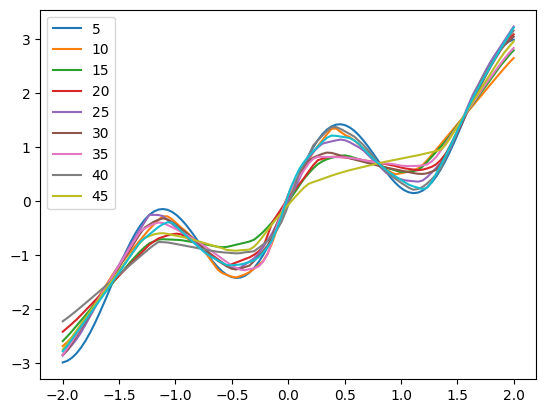

In [63]:
plt.plot(X, y)
for y_hats in depth_to_yhats.values():
    plt.plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
plt.legend([str(depth) for depth in depth_to_yhats.keys()]);

In [64]:
%%time
X = xvalues # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

depth_to_yhats = {}
for num_layers in np.arange(10, 100, 10):
    reset_env(NUM_LAYERS=num_layers)
    layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
    env = TargetNetwork(
        X, 
        y, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    metarl = A2C('MlpPolicy', env)
    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    print(f'depth {num_layers}:  {y_hats}')
    depth_to_yhats[num_layers] = y_hats

depth 10:  [tensor([-2.9578], grad_fn=<AddBackward0>), tensor([-2.8413], grad_fn=<AddBackward0>), tensor([-2.7201], grad_fn=<AddBackward0>), tensor([-2.5898], grad_fn=<AddBackward0>), tensor([-2.4468], grad_fn=<AddBackward0>), tensor([-2.2985], grad_fn=<AddBackward0>), tensor([-2.1501], grad_fn=<AddBackward0>), tensor([-2.0018], grad_fn=<AddBackward0>), tensor([-1.8535], grad_fn=<AddBackward0>), tensor([-1.7052], grad_fn=<AddBackward0>), tensor([-1.5538], grad_fn=<AddBackward0>), tensor([-1.3997], grad_fn=<AddBackward0>), tensor([-1.2456], grad_fn=<AddBackward0>), tensor([-1.1174], grad_fn=<AddBackward0>), tensor([-1.0031], grad_fn=<AddBackward0>), tensor([-0.8888], grad_fn=<AddBackward0>), tensor([-0.7745], grad_fn=<AddBackward0>), tensor([-0.6663], grad_fn=<AddBackward0>), tensor([-0.5694], grad_fn=<AddBackward0>), tensor([-0.4955], grad_fn=<AddBackward0>), tensor([-0.4298], grad_fn=<AddBackward0>), tensor([-0.4184], grad_fn=<AddBackward0>), tensor([-0.4353], grad_fn=<AddBackward0>),

### 10 -> 100 depth networks (10 step size)

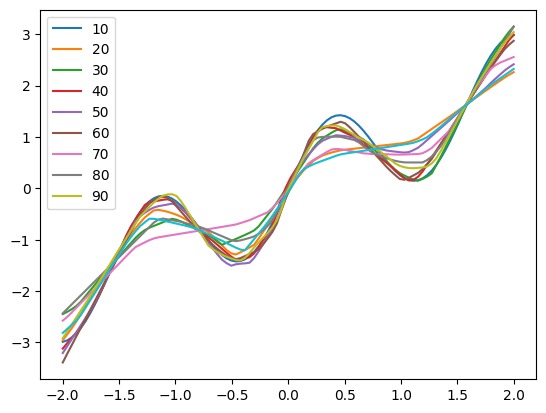

In [66]:
plt.plot(X, y)
for y_hats in depth_to_yhats.values():
    plt.plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
plt.legend([str(depth) for depth in depth_to_yhats.keys()]);

### 10 -> 1010 depth networks (1000 step size)

In [67]:
%%time
X = xvalues # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

depth_to_yhats = {}
for num_layers in np.arange(10, 10010, 1000):
    reset_env(NUM_LAYERS=num_layers)
    layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
    env = TargetNetwork(
        X, 
        y, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    metarl = A2C('MlpPolicy', env)
    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    print(f'depth {num_layers}:  {y_hats}')
    depth_to_yhats[num_layers] = y_hats

depth 10:  [tensor([-2.6770], grad_fn=<AddBackward0>), tensor([-2.5701], grad_fn=<AddBackward0>), tensor([-2.4563], grad_fn=<AddBackward0>), tensor([-2.3424], grad_fn=<AddBackward0>), tensor([-2.2285], grad_fn=<AddBackward0>), tensor([-2.1142], grad_fn=<AddBackward0>), tensor([-1.9919], grad_fn=<AddBackward0>), tensor([-1.8697], grad_fn=<AddBackward0>), tensor([-1.7474], grad_fn=<AddBackward0>), tensor([-1.6242], grad_fn=<AddBackward0>), tensor([-1.5009], grad_fn=<AddBackward0>), tensor([-1.3776], grad_fn=<AddBackward0>), tensor([-1.2544], grad_fn=<AddBackward0>), tensor([-1.1311], grad_fn=<AddBackward0>), tensor([-1.0078], grad_fn=<AddBackward0>), tensor([-0.8845], grad_fn=<AddBackward0>), tensor([-0.7615], grad_fn=<AddBackward0>), tensor([-0.6402], grad_fn=<AddBackward0>), tensor([-0.5265], grad_fn=<AddBackward0>), tensor([-0.4165], grad_fn=<AddBackward0>), tensor([-0.3581], grad_fn=<AddBackward0>), tensor([-0.3035], grad_fn=<AddBackward0>), tensor([-0.2515], grad_fn=<AddBackward0>),

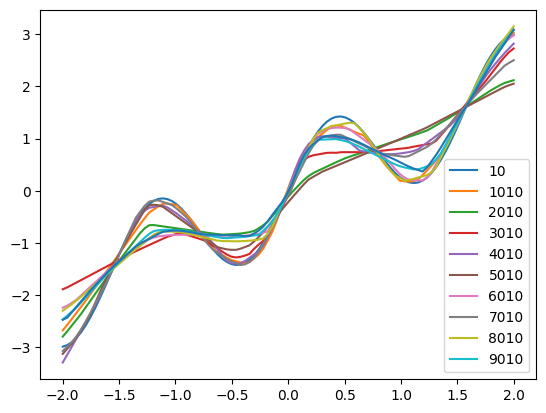

In [68]:
plt.plot(X, y)
for y_hats in depth_to_yhats.values():
    plt.plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
plt.legend([str(depth) for depth in depth_to_yhats.keys()]);

### Experiment: layer reuse on multiple tasks

In [ ]:
print_env()

POOL_NUM_LAYERS  1000
NETWORK_DEPTH  5
NETWORK_NUM_NODES  32
NUM_TASKS  20
SEED  123
LOSS_FN  MSELoss()
EPOCHS  1000
MODEL  Sequential(
  (0): Linear(in_features=1, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=24, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24, out_features=1, bias=True)
)
OPT  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
TIMESTEPS  20000
DEVICE  cpu


### Baby example with just 1 epoch
However, 1 epoch is still going through all 20 tasks, generating 20 different networks, using the same 1 meta policy. Also, on each task we loop through the data 1000 times (timesteps / len(X) == 10000 / 100).
<br>
The benefit of more epochs is we get the meta policy to gnerate 20 different networks again for the 20 tasks, having hopefully learned something from the first run.

In [73]:
TIMESTEPS=5000
NUM_TASKS=20
NETWORK_DEPTH=5
POOL_NUM_LAYERS=calculate_pool_size(NUM_TASKS, NETWORK_DEPTH)
EPOCHS=1

In [74]:
X = xvalues # (100,1) <- np.linspace(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

In [75]:
# create tasks
tasks = {
    str(round(f))+str("_task") : (xvalues, 
                                  (A*np.sin(f*xvalues) + np.random.normal(0, 0.2, 100))) 
                                  for A, f in zip(np.linspace(1, NUM_TASKS, NUM_TASKS), np.linspace(1, NUM_TASKS, NUM_TASKS))
    }

In [76]:
# create pool
pool = LayerPool(size=POOL_NUM_LAYERS, input_dim=in_features, output_dim=out_features, num_nodes=NETWORK_NUM_NODES)

In [77]:
%%time
# train outer-loop on 20 tasks
rml = Rlmetalearn(pool, tasks, epsilon=0.1)

CPU times: total: 0 ns
Wall time: 0 ns


In [78]:
%%time
rml.train()

[INFO] Epoch 1/1...
[INFO] ...task 1/20
epoch to yhats {'1_task': [tensor([-1.1521], grad_fn=<AddBackward0>), tensor([-1.1352], grad_fn=<AddBackward0>), tensor([-1.1180], grad_fn=<AddBackward0>), tensor([-1.1008], grad_fn=<AddBackward0>), tensor([-1.0837], grad_fn=<AddBackward0>), tensor([-1.0665], grad_fn=<AddBackward0>), tensor([-1.0494], grad_fn=<AddBackward0>), tensor([-1.0322], grad_fn=<AddBackward0>), tensor([-1.0150], grad_fn=<AddBackward0>), tensor([-0.9979], grad_fn=<AddBackward0>), tensor([-0.9807], grad_fn=<AddBackward0>), tensor([-0.9635], grad_fn=<AddBackward0>), tensor([-0.9464], grad_fn=<AddBackward0>), tensor([-0.9292], grad_fn=<AddBackward0>), tensor([-0.9120], grad_fn=<AddBackward0>), tensor([-0.8949], grad_fn=<AddBackward0>), tensor([-0.8777], grad_fn=<AddBackward0>), tensor([-0.8606], grad_fn=<AddBackward0>), tensor([-0.8434], grad_fn=<AddBackward0>), tensor([-0.8262], grad_fn=<AddBackward0>), tensor([-0.8089], grad_fn=<AddBackward0>), tensor([-0.7910], grad_fn=<Add

In [79]:
rml.save()

In [25]:
with open('192519_yhats.pkl', 'rb') as fp:
    yhatsd = pickle.load(fp)
print(yhatsd.keys())

dict_keys([0])


In [80]:
yhats, indices, pool = rml.load()

In [81]:
yhats # { task : yhats } where we have 20 tasks, and 100 yhats for 1 tasks

{0: {'1_task': [tensor([-1.1521], requires_grad=True),
   tensor([-1.1352], requires_grad=True),
   tensor([-1.1180], requires_grad=True),
   tensor([-1.1008], requires_grad=True),
   tensor([-1.0837], requires_grad=True),
   tensor([-1.0665], requires_grad=True),
   tensor([-1.0494], requires_grad=True),
   tensor([-1.0322], requires_grad=True),
   tensor([-1.0150], requires_grad=True),
   tensor([-0.9979], requires_grad=True),
   tensor([-0.9807], requires_grad=True),
   tensor([-0.9635], requires_grad=True),
   tensor([-0.9464], requires_grad=True),
   tensor([-0.9292], requires_grad=True),
   tensor([-0.9120], requires_grad=True),
   tensor([-0.8949], requires_grad=True),
   tensor([-0.8777], requires_grad=True),
   tensor([-0.8606], requires_grad=True),
   tensor([-0.8434], requires_grad=True),
   tensor([-0.8262], requires_grad=True),
   tensor([-0.8089], requires_grad=True),
   tensor([-0.7910], requires_grad=True),
   tensor([-0.7728], requires_grad=True),
   tensor([-0.7544], 

In [82]:
indices # error. it shouldn't be empty

{}

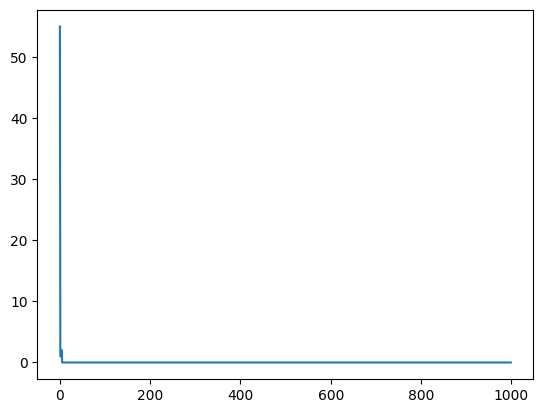

In [29]:
times_each_layer_used = [layer.times_used for layer in pool.layers.values()]
plt.plot(range(1000), times_each_layer_used)
# not a good graph, this shows that only the first few layers get used and most don't get touched
# but I thought I had less than 1000 layers for that reason

In [43]:
len(yhats[0])

20

### Loss w/ transfer vs. w/o transfer

In [ ]:
# y - loss
# x - timesteps

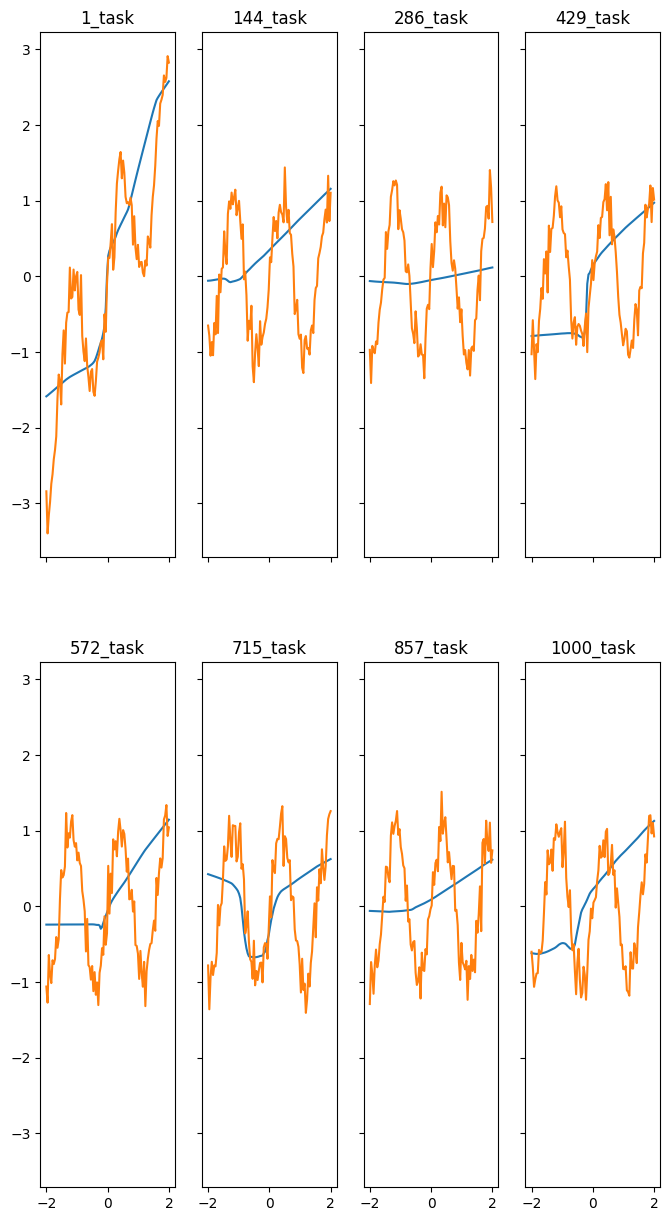

In [74]:
# PRINT PLOTS
rows = 2
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(8,15))
k = 0
for i in range(rows):
    for j in range(cols):
        task = list(task_to_yhats.keys())[k]
        y_hats = task_to_yhats[task]
        axs[i, j].plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
        axs[i, j].plot(X, list(tasks.items())[k][1])
        axs[i,j].set_title(task)
        k+=1